<strong>Requirement:</strong>
   - Read dataset
   - Pre-process data
   - Use K-means clustering algorith to cluster 3D points in data3D.csv

In [ ]:
import findspark
findspark.init()

In [2]:
import pyspark

In [3]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName('kmeans_3D_porint').getOrCreate()

In [8]:
# Loads data
data = spark.read.csv('data/data3D.csv', header = True, 
                      inferSchema = True)

In [9]:
data.show(3)

+------+-----------------+------------------+------------------+
|    id|                x|                 y|                 z|
+------+-----------------+------------------+------------------+
|point0|5.647627534046943|-6.356222340123802|-7.240816026826695|
|point1|4.414367138680041|-10.32624175635328| 8.963324308916228|
|point2|5.005396944639823|-9.301070062115645| 10.35473056351597|
+------+-----------------+------------------+------------------+
only showing top 3 rows



In [10]:
from pyspark.sql.functions import col

In [11]:
data = data.select(['x', 'y', 'z'])

In [12]:
data.show(3)

+-----------------+------------------+------------------+
|                x|                 y|                 z|
+-----------------+------------------+------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|
|4.414367138680041|-10.32624175635328| 8.963324308916228|
|5.005396944639823|-9.301070062115645| 10.35473056351597|
+-----------------+------------------+------------------+
only showing top 3 rows



## Format from data

In [13]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [14]:
data.columns

['x', 'y', 'z']

In [15]:
vec_assembler = VectorAssembler(inputCols = data.columns, 
                                outputCol = 'features')

In [16]:
final_data = vec_assembler.transform(data)

## Scale the Data

In [17]:
from pyspark.ml.feature import StandardScaler

In [18]:
scaler = StandardScaler(inputCol = 'features', 
                        outputCol = 'scaledFeatures',
                        withStd = True, 
                        withMean = False)

In [19]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [20]:
# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

In [21]:
final_data.show(3, False)

+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+
|x                |y                 |z                 |features                                                 |scaledFeatures                                              |
+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.647627534046943,-6.356222340123802,-7.240816026826695]|[1.0159673512169787,-0.8133579916042428,-1.1300631023636816]|
|4.414367138680041|-10.32624175635328|8.963324308916228 |[4.414367138680041,-10.32624175635328,8.963324308916228] |[0.7941127247055377,-1.321371532702518,1.398892340103383]   |
|5.005396944639823|-9.301070062115645|10.35473056351597 |[5.005396944639823,-9.301070062115645,10.35473056351597] |

## Tran the Model and Evaluate
### Select k with minimum WSSSE: k between 2 - 10

In [22]:
from pyspark.ml.clustering import KMeans

In [24]:
# Trains a k-means model.
k_list = []
wssse_list = []
for k in range (2, 11):
    kmeans = KMeans(featuresCol = 'scaledFeatures', k = k)
    model = kmeans.fit(final_data)
    wssse = model.computeCost(final_data)
    k_list.append(k)
    wssse_list.append(wssse)
    print('With k =', k, 'Set Sum of Squared Errors =' + str(wssse))

With k = 2 Set Sum of Squared Errors =1523419.5907293265
With k = 3 Set Sum of Squared Errors =297656.40920043166
With k = 4 Set Sum of Squared Errors =223658.0897194126
With k = 5 Set Sum of Squared Errors =72720.18503668565
With k = 6 Set Sum of Squared Errors =68584.57168275898
With k = 7 Set Sum of Squared Errors =64343.72812033371
With k = 8 Set Sum of Squared Errors =60212.439958338146
With k = 9 Set Sum of Squared Errors =56067.60743958394
With k = 10 Set Sum of Squared Errors =54091.69994867606


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

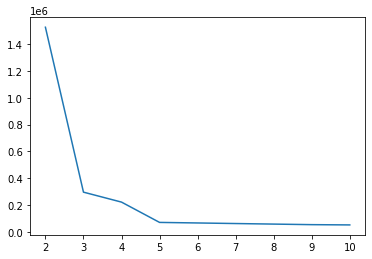

In [26]:
plt.plot(k_list, wssse_list)
plt.show()

- According to Elbow Method, we choose k = 5. Look like there is very little gain after k = 5, so we stick to that choive when processing the full dataset

### <strong>Select k = 5</strong>

In [27]:
# Train a k-means model.
kmeans = KMeans(featuresCol = 'scaledFeatures', k=5)
model = kmeans.fit(final_data)

In [28]:
# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(final_data)
print('Within Set Sum of Squared Errors = ' + str(wssse))

Within Set Sum of Squared Errors = 72720.18503668565


In [29]:
# Shows the result.
centers = model.clusterCenters()
print('Cluster Centers: ')
for center in centers:
    print(center)

Cluster Centers: 
[ 1.19780907 -0.73650031 -0.99420862]
[-1.59030525  0.93719373  0.31581855]
[ 0.74896823 -1.2269015   1.46702482]
[ 0.35334174 -0.87989203 -1.07356186]
[-0.45182036  1.15367577  0.72369935]


In [30]:
predictions = model.transform(final_data)

In [33]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         0|
|         2|
|         2|
|         2|
|         1|
+----------+
only showing top 5 rows



In [34]:
# Check number points of each cluster
predictions.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1|199983|
|         3|200014|
|         4|200017|
|         2|200000|
|         0|199986|
+----------+------+



- Our clustering algorith created 5 equally sized clusters with k = 5

In [36]:
data_result = predictions.select('prediction')
data_result.columns

['prediction']

In [37]:
type(data_result)

pyspark.sql.dataframe.DataFrame

In [38]:
final_data.show(3, False)

+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+
|x                |y                 |z                 |features                                                 |scaledFeatures                                              |
+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.647627534046943,-6.356222340123802,-7.240816026826695]|[1.0159673512169787,-0.8133579916042428,-1.1300631023636816]|
|4.414367138680041|-10.32624175635328|8.963324308916228 |[4.414367138680041,-10.32624175635328,8.963324308916228] |[0.7941127247055377,-1.321371532702518,1.398892340103383]   |
|5.005396944639823|-9.301070062115645|10.35473056351597 |[5.005396944639823,-9.301070062115645,10.35473056351597] |

In [43]:
temp = final_data.select('scaledFeatures').rdd.map(lambda x: \
                                                  x[0].toArray().tolist()).toDF()

In [44]:
temp.show(3)

+------------------+-------------------+-------------------+
|                _1|                 _2|                 _3|
+------------------+-------------------+-------------------+
|1.0159673512169787|-0.8133579916042428|-1.1300631023636816|
|0.7941127247055377| -1.321371532702518|  1.398892340103383|
|0.9004347126254751|-1.1901880174546229|  1.616046989924021|
+------------------+-------------------+-------------------+
only showing top 3 rows



In [45]:
import pyspark.sql.functions as f

In [47]:
# since there is no common column between these two dataframes add row_index so
temp = temp.withColumn('row_index', f.monotonically_increasing_id())
data_result = data_result.withColumn('row_index', 
                                    f.monotonically_increasing_id())
temp = temp.join(data_result,
                on=['row_index']).sort('row_index').drop('row_index')

In [48]:
temp.show(3)

+------------------+-------------------+-------------------+----------+
|                _1|                 _2|                 _3|prediction|
+------------------+-------------------+-------------------+----------+
|1.0159673512169787|-0.8133579916042428|-1.1300631023636816|         0|
|0.7941127247055377| -1.321371532702518|  1.398892340103383|         2|
|0.9004347126254751|-1.1901880174546229|  1.616046989924021|         2|
+------------------+-------------------+-------------------+----------+
only showing top 3 rows



In [49]:
temp = temp.select(col('_1').alias('x_scale'),
                   col('_2').alias('y_scale'),
                   col('_3').alias('z_scale'),
                   'prediction')

In [50]:
df = temp.toPandas()

In [51]:
df.head(3)

,x_scale,y_scale,z_scale,prediction
0,1.015967,-0.813358,-1.130063,0
1,0.794113,-1.321372,1.398892,2
2,0.900435,-1.190188,1.616047,2


In [52]:
centers_df = pd.DataFrame(centers)
centers_df.head()

,0,1,2
0,1.197809,-0.736500,-0.994209
1,-1.590305,0.937194,0.315819
2,0.748968,-1.226902,1.467025
3,0.353342,-0.879892,-1.073562
4,-0.451820,1.153676,0.723699


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

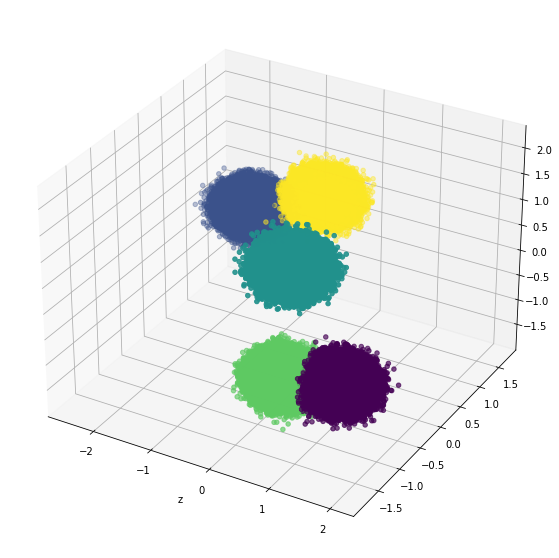

In [54]:
threedee = plt.figure(figsize=(12, 10)).gca(projection='3d')
threedee.scatter(df.x_scale, df.y_scale,
                 df.z_scale, 
                 c = df.prediction)
threedee.set_xlabel('x')
threedee.set_xlabel('y')
threedee.set_xlabel('z')
plt.show()

In [55]:
# since there is no common column between these two dataframes add row_index so
final_data = final_data.withColumn('row_index', 
                                    f.monotonically_increasing_id())

temp = temp.withColumn('row_index', f.monotonically_increasing_id())

final_data = final_data.join(temp,
                on=['row_index']).sort('row_index').drop('row_index')

In [57]:
final_data.show(3, False)

+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+------------------+-------------------+-------------------+----------+
|x                |y                 |z                 |features                                                 |scaledFeatures                                              |x_scale           |y_scale            |z_scale            |prediction|
+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+------------------+-------------------+-------------------+----------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.647627534046943,-6.356222340123802,-7.240816026826695]|[1.0159673512169787,-0.8133579916042428,-1.1300631023636816]|1.0159673512169787|-0.8133579916042428|-1.1300631023636816|0         |
|4.414367138